In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import resnet_v2
import tensorflow as tf
from training import get_labels_from_annotation_batch
slim = tf.contrib.slim
from scipy.misc import imread
import numpy as np
from tensorflow.python.ops import control_flow_ops

In [2]:
#0:   background
#1:   roads
#2:   buildings
#255: undefined/don't care
number_of_classes = 3
class_labels = [v for v in range((number_of_classes+1))]
class_labels[-1] = 255
print(class_labels)

[0, 1, 2, 255]


In [3]:
def model_input():
    # Create and return the placeholders for receiving data
    batch_images_placeholder = tf.placeholder(tf.float32, shape=[None, None, None, 3])
    batch_labels_placeholder = tf.placeholder(tf.uint8, shape=[None, None, None])
    is_training_placeholder = tf.placeholder(tf.bool, name="is_training_placeholder")
    keep_prob = tf.placeholder(tf.float32, name="dropout_keep_probability")
    return batch_images_placeholder, batch_labels_placeholder, is_training_placeholder, keep_prob

In [4]:
@slim.add_arg_scope
def block_unit(net, k, id, keep_prob=1.0):
    # block_unit implements a bottleneck layer 
    with tf.variable_scope("block_unit_" + str(id)):
        
        # each 1×1 convolution produce 4k feature-maps
        net = slim.conv2d(net, 4*k, [1,1], scope="conv1", activation_fn=None, normalizer_fn=None)
        net = slim.dropout(net, keep_prob, scope='dropout1')
        net = slim.batch_norm(net, activation_fn=tf.nn.relu)

        net = slim.conv2d(net, k, [3,3], scope="conv3x3", activation_fn=None, normalizer_fn=None)
        net = slim.dropout(net, keep_prob, scope='dropout2')
        net = slim.batch_norm(net, activation_fn=tf.nn.relu)
        return net

In [5]:
@slim.add_arg_scope
def add_transition_layer(net, id):
    # We use 1×1 convolution followed by 2×2 average pooling as transition layers between two contiguous dense blocks
    with tf.variable_scope("transition_layer_" + str(id)):  
        current_depth = slim.utils.last_dimension(net.get_shape(), min_rank=4)

        net = slim.batch_norm(net, activation_fn=tf.nn.relu)
        net = slim.conv2d(net, theta*current_depth, [1,1], scope='conv1x1', 
                          activation_fn=None, normalizer_fn=None)
        net = slim.dropout(net, keep_prob, scope='dropout')
        net = slim.avg_pool2d(net, [2,2], scope='avg_pool', stride=2)
        return net

In [6]:
@slim.add_arg_scope
def add_upsampling_layer(net, resize_to, id):
    # Resize layer
    with tf.variable_scope("resize_layer_" + str(id)):
        depth = slim.utils.last_dimension(net.get_shape(), min_rank=4)
        net = slim.batch_norm(net, activation_fn=tf.nn.relu)
        net = tf.image.resize_nearest_neighbor(net, resize_to)
        net = slim.conv2d(net, depth, [1,1], scope='conv1x1',
                         activation_fn=None, normalizer_fn=None)
        return net

In [7]:
def encoder_decoder(batch_images, number_of_classes, k, theta, is_training, keep_prob, batch_norm_decay=0.997, batch_norm_epsilon=1e-5):

    batch_norm_params = {
      'decay': batch_norm_decay,
      'epsilon': batch_norm_epsilon,
      'scale': True,
      'is_training': is_training,
      'updates_collections': tf.GraphKeys.UPDATE_OPS,
    }

    # batch_images shape (?, 224,224,3)
    with slim.arg_scope([slim.conv2d], padding='SAME',
                        weights_initializer=slim.variance_scaling_initializer(),
                        activation_fn=tf.nn.relu,
                        stride=1,
                        normalizer_fn=slim.batch_norm,
                        normalizer_params=batch_norm_params,
                        weights_regularizer=slim.l2_regularizer(0.0001)):

        with slim.arg_scope([slim.batch_norm], **batch_norm_params):

            # We refer to layers between blocks as transition layers, which do convolution and pooling
            # net = slim.conv2d(batch_images, 2*k, [7,7], scope='conv1')
            # net = slim.max_pool2d(net, [3,3], scope='pool1') # (?,56,56,2*k)

            net = slim.conv2d(batch_images, 2*k, [3,3], scope='conv1')

            with tf.variable_scope("dense_block_1"):
                unit1 = block_unit(net, k, 1)

                unit2 = block_unit(unit1, k, 2)
                unit1_2 = tf.concat((unit1, unit2), axis=3, name="unit1_2")

                unit3 = block_unit(unit1_2, k, 3)
                unit1_2_3 = tf.concat((unit1_2, unit3), axis=3, name="unit1_2_3")

                unit4 = block_unit(unit1_2_3, k, 4)
                unit1_2_3_4 = tf.concat((unit1_2_3, unit4), axis=3, name="unit1_2_3_4")

                unit5 = block_unit(unit1_2_3_4, k, 5)
                block_1 = tf.concat((unit1_2_3_4, unit5), axis=3, name="unit1_2_3_4_5")
                
            net = add_transition_layer(block_1, 1)

            with tf.variable_scope("dense_block_2"):
                unit1 = block_unit(net, k, 1)

                unit2 = block_unit(unit1, k, 2)
                unit1_2 = tf.concat((unit1, unit2), axis=3, name="unit1_2")

                unit3 = block_unit(unit1_2, k, 3)
                unit1_2_3 = tf.concat((unit1_2, unit3), axis=3, name="unit1_2_3")

                unit4 = block_unit(unit1_2_3, k, 4)
                unit1_2_3_4 = tf.concat((unit1_2_3, unit4), axis=3, name="unit1_2_3_4")

                unit5 = block_unit(unit1_2_3_4, k, 5)
                block_2 = tf.concat((unit1_2_3_4, unit5), axis=3, name="unit1_2_3_4_5")

            net = add_transition_layer(block_2, 2)

            with tf.variable_scope("dense_block_3"):
                unit1 = block_unit(net, k, 1)

                unit2 = block_unit(unit1, k, 2)
                unit1_2 = tf.concat((unit1, unit2), axis=3, name="unit1_2")

                unit3 = block_unit(unit1_2, k, 3)
                unit1_2_3 = tf.concat((unit1_2, unit3), axis=3, name="unit1_2_3")

                unit4 = block_unit(unit1_2_3, k, 4)
                unit1_2_3_4 = tf.concat((unit1_2_3, unit4), axis=3, name="unit1_2_3_4")

                unit5 = block_unit(unit1_2_3_4, k, 5)
                block_3 = tf.concat((unit1_2_3_4, unit5), axis=3, name="unit1_2_3_4_5")
            
            #####################################
            # DenseNet based Decoder
            #####################################
            
            block_2_shape = tf.shape(block_2)
            new_size = (block_2_shape[1], block_2_shape[2])
            net = add_upsampling_layer(block_3, resize_to=new_size, id=1)
                
            # net = tf.concat((net, block_2), axis=3, name="fuse_block_2")
            
            with tf.variable_scope("dense_block_4"):
                unit1 = block_unit(net, number_of_classes, 1)

                unit2 = block_unit(unit1, number_of_classes, 2)
                unit1_2 = tf.concat((unit1, unit2), axis=3, name="unit1_2")

                unit3 = block_unit(unit1_2, number_of_classes, 3)
                unit1_2_3 = tf.concat((unit1_2, unit3), axis=3, name="unit1_2_3")

                unit4 = block_unit(unit1_2_3, number_of_classes, 4)
                unit1_2_3_4 = tf.concat((unit1_2_3, unit4), axis=3, name="unit1_2_3_4")

                unit5 = block_unit(unit1_2_3_4, number_of_classes, 5)
                block_4 = tf.concat((unit1_2_3_4, unit5), axis=3, name="unit1_2_3_4_5")
            
            block_1_shape = tf.shape(block_1)
            new_size = (block_1_shape[1], block_1_shape[2])
            net = add_upsampling_layer(block_4, resize_to=new_size, id=2)
                  
            # net = tf.concat((net, block_1), axis=3, name="fuse_block_1")
            
            with tf.variable_scope("dense_block_5"):
                unit1 = block_unit(net, number_of_classes, 1)

                unit2 = block_unit(unit1, number_of_classes, 2)
                unit1_2 = tf.concat((unit1, unit2), axis=3, name="unit1_2")

                unit3 = block_unit(unit1_2, number_of_classes, 3)
                unit1_2_3 = tf.concat((unit1_2, unit3), axis=3, name="unit1_2_3")

                unit4 = block_unit(unit1_2_3, number_of_classes, 4)
                unit1_2_3_4 = tf.concat((unit1_2_3, unit4), axis=3, name="unit1_2_3_4")

                unit5 = block_unit(unit1_2_3_4, number_of_classes, 5)
                block_5 = tf.concat((unit1_2_3_4, unit5), axis=3, name="unit1_2_3_4_5")
            
            net = slim.batch_norm(block_5, activation_fn=tf.nn.relu)
            net = slim.conv2d(net, number_of_classes, (3,3), activation_fn=None, normalizer_fn=None)
            return net

In [8]:
def model_loss(logits, labels, class_labels):
    "Returns the cross entropy mean to be minimized, the predictions for each pixel and the probabilities."
    annotation_mask = get_labels_from_annotation_batch(labels, class_labels)

    cross_entropies = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                              labels=annotation_mask)

    cross_entropy_mean = tf.reduce_mean(cross_entropies)
    
    # Add summary op for the loss -- to be able to see it in tensorboard.
    tf.summary.scalar('cross_entropy_loss', cross_entropy_mean)

    # Tensor to get the final prediction for each pixel -- pay 
    # attention that we don't need softmax in this case because
    # we only need the final decision. If we also need the respective
    # probabilities we will have to apply softmax.
    pred = tf.argmax(logits, dimension=3)
    probabilities = tf.nn.softmax(logits)
    
    return cross_entropy_mean, pred, probabilities

In [9]:
def read_image_and_annotation(train_images_dir, train_annotations_dir, image_name):
    # read the input and annotation images
    image = imread(train_images_dir + image_name.strip() + ".tiff")
    annotation = imread(train_annotations_dir + image_name.strip() + ".tif")
    #assert (image.dtype) == "uint8"
    #assert (annotation.dtype) == "uint8"
    #image = image - [_R_MEAN, _G_MEAN, _B_MEAN]
    
    image = (image - 128.) / 128.
    
    return image.astype(np.float32), annotation

In [10]:
def random_crop(image_np, annotation_np, crop_size=128):
    """
    image_np: rgb image shape (H,W,3)
    annotation_np: 1D image shape (H,W,1)
    crop_size: integer
    """
    image_h = image_np.shape[0]
    image_w = image_np.shape[1]
    
    random_x = np.random.randint(0, image_w-crop_size+1) # Return random integers from low (inclusive) to high (exclusive).
    random_y = np.random.randint(0, image_h-crop_size+1) # Return random integers from low (inclusive) to high (exclusive).
    
    offset_x = random_x + crop_size
    offset_y = random_y + crop_size
    
    return image_np[random_x:offset_x, random_y:offset_y,:], annotation_np[random_x:offset_x, random_y:offset_y]

In [11]:
def next_batch(train_images_dir, train_annotations_dir, image_filenames_list, crop_image=True, batch_size=5, crop_size=128):
    
    for image_name in image_filenames_list:
        
        image_np, annotation_np = read_image_and_annotation(train_images_dir, train_annotations_dir, image_name)
            
        batch_images = None
        batch_labels = None
        
        for batch_i in range(batch_size):
            cropped_image, cropped_annotation = random_crop(image_np, annotation_np, crop_size)
            cropped_image = np.expand_dims(cropped_image, axis=0)
            cropped_annotation = np.expand_dims(cropped_annotation, axis=0)
            
            if batch_images is None:
                batch_images = cropped_image
                batch_labels = cropped_annotation
            else:
                #print(batch_images.shape, cropped_image.shape)
                batch_images = np.concatenate((batch_images, cropped_image), axis=0)
                batch_labels = np.concatenate((batch_labels, cropped_annotation), axis=0)
    
        yield batch_images, batch_labels

In [12]:
k=12
theta=1.0 # compression_factor
batch_norm_decay = 0.997
batch_norm_epsilon = 1e-5,

In [13]:
# get the model placeholders
batch_images_placeholder, batch_labels_placeholder, is_training_placeholder, keep_prob = model_input()

logits = encoder_decoder(batch_images_placeholder, number_of_classes, k, theta, is_training_placeholder, keep_prob)

# get the error and predictions from the network
cross_entropy, pred, probabilities = model_loss(logits, batch_labels_placeholder, class_labels)

In [14]:
# Example: decay from 0.01 to 0.0001 in 10000 steps using sqrt (i.e. power=1. linearly):
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.1
end_learning_rate = 0.001
decay_steps = 62400
learning_rate = tf.train.polynomial_decay(starter_learning_rate, global_step,
                                          decay_steps, end_learning_rate,
                                          power=1)
tf.summary.scalar('learning_rate', learning_rate)

optimizer = tf.train.MomentumOptimizer(learning_rate=0.1, momentum=0.9)
#optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

train_step = slim.learning.create_train_op(cross_entropy, optimizer, global_step=global_step)

In [15]:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
if update_ops:
    updates = tf.group(*update_ops)
    cross_entropy = control_flow_ops.with_dependencies([updates], cross_entropy)

In [16]:
# Define the accuracy metric: Mean Intersection Over Union
miou, update_op = slim.metrics.streaming_mean_iou(predictions=pred,
                                                   labels=batch_labels_placeholder,
                                                   num_classes=number_of_classes)

In [17]:
import os
log_folder = '/home/thalles/log_folder'

# Put all summary ops into one op. Produces string when you run it.
merged_summary_op = tf.summary.merge_all()
log_folder = os.path.join(log_folder, str(os.getpid()))
# Create the log folder if doesn't exist yet
if not os.path.exists(log_folder):
    print(log_folder)
    os.makedirs(log_folder)

/home/thalles/log_folder/4671


In [18]:
# define the images and annotations path
base_dataset_dir = "/home/thalles/mass_merged/"
train_dataset_base_dir = os.path.join(base_dataset_dir, "train")
images_folder_name = "sat/"
annotations_folder_name = "map/"
train_images_dir = os.path.join(train_dataset_base_dir, images_folder_name)
train_annotations_dir = os.path.join(train_dataset_base_dir, annotations_folder_name)

In [19]:
# read the train.txt file. This file contains the training images' names
file = open(os.path.join(train_dataset_base_dir, "train.txt"), 'r')
images_filename_list = [line for line in file]

images_filename_list = images_filename_list[:4]
print(len(images_filename_list))

4


In [20]:
# define the images and annotations path
val_dataset_base_dir = os.path.join(base_dataset_dir, "valid")
val_images_dir = os.path.join(val_dataset_base_dir, images_folder_name)
val_annotations_dir = os.path.join(val_dataset_base_dir, annotations_folder_name)

In [ ]:
# read the train.txt file. This file contains the training images' names
file = open(os.path.join(val_dataset_base_dir, "val.txt"), 'r')
val_images_filename_list = [line for line in file]

val_images_filename_list = val_images_filename_list[:2]
print(val_images_filename_list)

['22978945_15\n', '23429155_15\n']


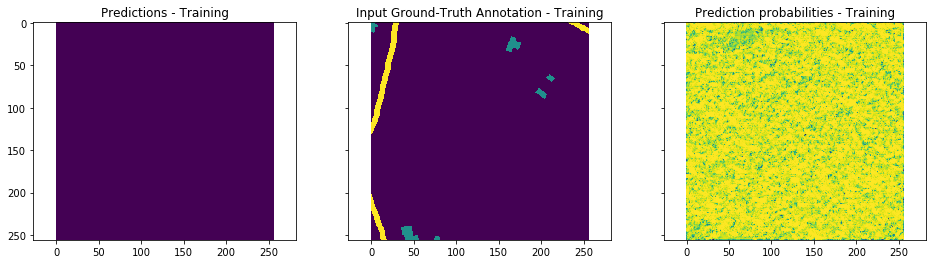

Epoch: 0 	Global step: 4 	Training loss: 0.386595 	Validation Loss: 0.848473 	mIOU: 0.273887 	Learning rate: 0.0999952


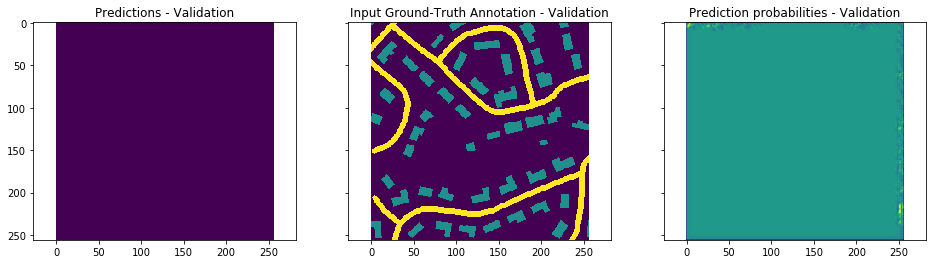

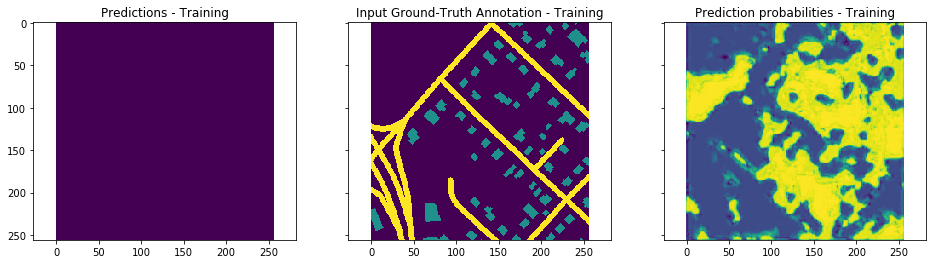

Epoch: 10 	Global step: 44 	Training loss: 0.700346 	Validation Loss: 0.737142 	mIOU: 0.278307 	Learning rate: 0.0999318


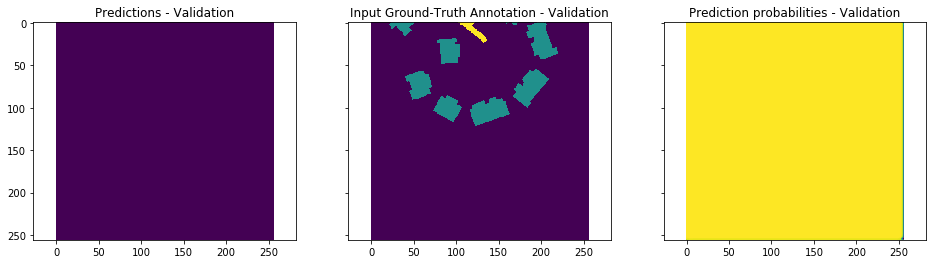

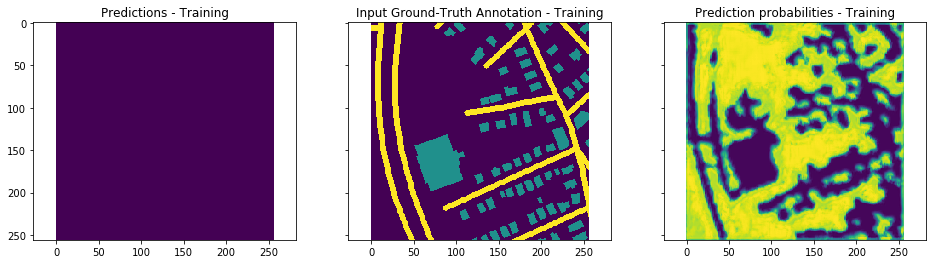

Epoch: 20 	Global step: 84 	Training loss: 0.520069 	Validation Loss: 1.29355 	mIOU: 0.281194 	Learning rate: 0.0998683


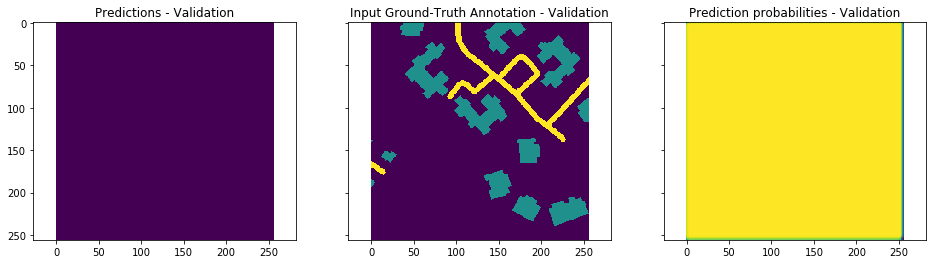

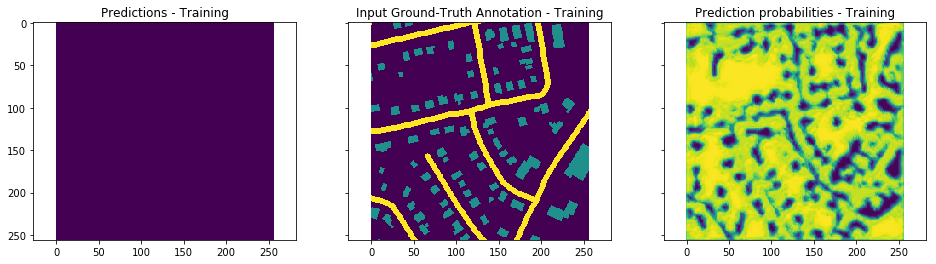

Epoch: 30 	Global step: 124 	Training loss: 0.475119 	Validation Loss: 0.55322 	mIOU: 0.28359 	Learning rate: 0.0998049


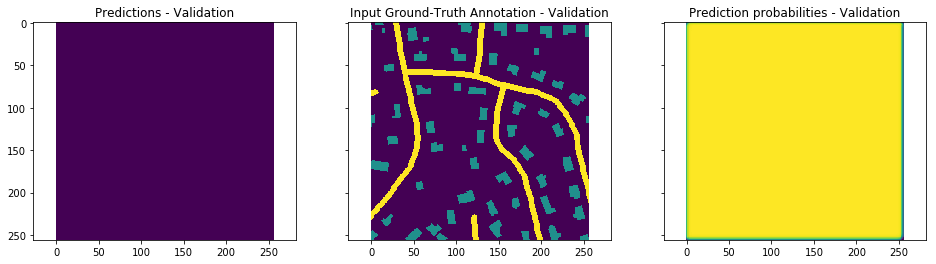

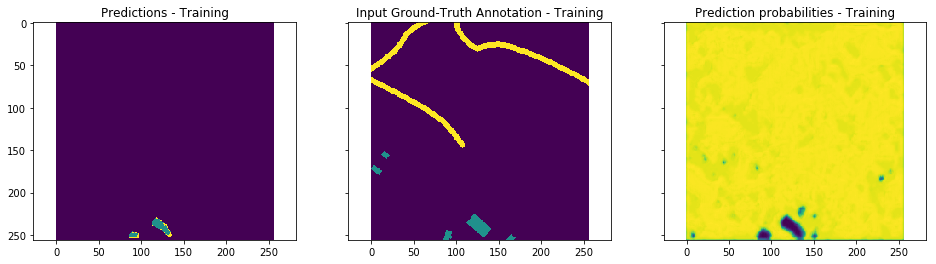

Epoch: 40 	Global step: 164 	Training loss: 0.372875 	Validation Loss: 0.408068 	mIOU: 0.286596 	Learning rate: 0.0997414


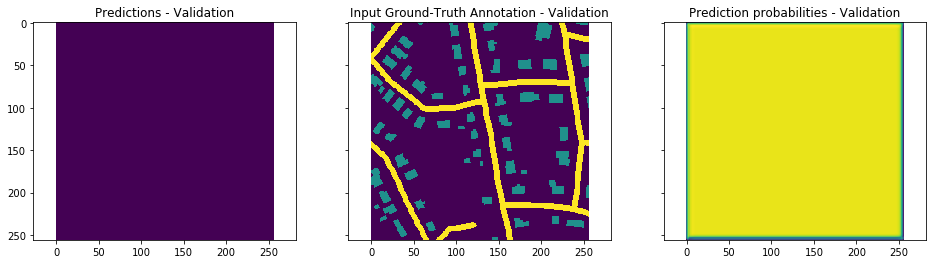

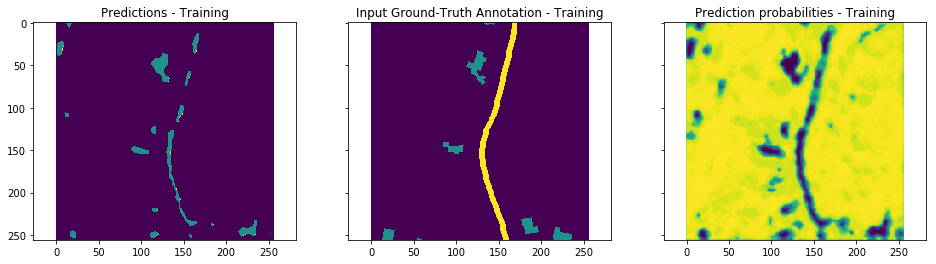

Epoch: 50 	Global step: 204 	Training loss: 0.314756 	Validation Loss: 0.551473 	mIOU: 0.285506 	Learning rate: 0.0996779


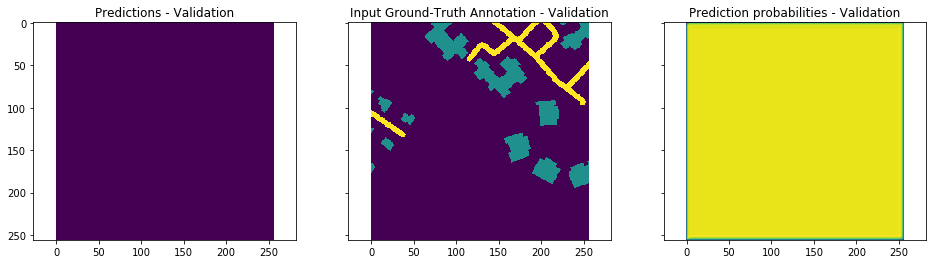

In [ ]:
total_training_loss = []
total_validation_loss = []
saver = tf.train.Saver()

with tf.Session() as sess:
    # Create the summary writer -- to write all the logs
    # into a specified file. This file can be later read
    # by tensorboard.
    summary_string_writer = tf.summary.FileWriter(log_folder, sess.graph)
    
    # Create a saver.
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    step = 0
    
    for epoch in range(200):

        for batch_image, batch_annotations in next_batch(train_images_dir, train_annotations_dir, images_filename_list, 
                                                         crop_image=True, batch_size=8, crop_size=256):
            # print(epoch, batch_image.shape)
            _, train_loss, pred_np, probabilities_np, summary_string, lr_np = sess.run([train_step, cross_entropy, pred, 
                                                                                 probabilities, merged_summary_op, learning_rate],
                                                        feed_dict={is_training_placeholder: True,
                                                                  batch_images_placeholder:batch_image,
                                                                  batch_labels_placeholder:batch_annotations,
                                                                  keep_prob: 1})
            summary_string_writer.add_summary(summary_string, step)
            step += 1

        if epoch % 10 == 0:
            cmap = plt.get_cmap('bwr')
            f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
            f.set_figheight(4)
            f.set_figwidth(16)

            ax1.imshow(pred_np[0])
            ax1.set_title('Predictions - Training')
            probability_graph = ax2.imshow(batch_annotations[0])
            ax2.set_title('Input Ground-Truth Annotation - Training')
            probability_graph = ax3.imshow(probabilities_np[0].squeeze()[:, :, 0])
            ax3.set_title('Prediction probabilities - Training')
            plt.show()
            
            total_miou_np = []
            total_val_loss = []
            for batch_images_val, batch_annotations_val in next_batch(val_images_dir, val_annotations_dir, val_images_filename_list, 
                                                             crop_image=True, batch_size=4, crop_size=256):

                global_step_np, val_loss, pred_np, probabilities_np, _ = sess.run([global_step, cross_entropy, pred, probabilities, update_op],
                                                                    feed_dict={is_training_placeholder: False,
                                                                              batch_images_placeholder:batch_images_val,
                                                                              batch_labels_placeholder:batch_annotations_val,
                                                                              keep_prob: 1})

                miou_np = sess.run(miou)
                total_val_loss.append(val_loss)
                total_miou_np.append(miou_np) 
            
            print("Epoch:", epoch, "\tGlobal step:", global_step_np, "\tTraining loss:", train_loss, "\tValidation Loss:", 
                  np.mean(total_val_loss), "\tmIOU:", np.mean(total_miou_np), "\tLearning rate:", lr_np)

            total_training_loss.append(train_loss)
            total_validation_loss.append(np.mean(total_val_loss))
            
            cmap = plt.get_cmap('bwr')
            f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
            f.set_figheight(4)
            f.set_figwidth(16)

            ax1.imshow(pred_np[0])
            ax1.set_title('Predictions - Validation')
            probability_graph = ax2.imshow(batch_annotations_val[0])
            ax2.set_title('Input Ground-Truth Annotation - Validation')
            probability_graph = ax3.imshow(probabilities_np[0].squeeze()[:, :, 0])
            ax3.set_title('Prediction probabilities - Validation')
            plt.show()
            
            # Save the variables to disk.
            save_path = saver.save(sess, "/tmp/model.ckpt")
            
        # at the end epoch shuffle the dataset list files
        np.random.shuffle(images_filename_list)
        np.random.shuffle(val_images_filename_list)

    summary_string_writer.close()